In [1]:
import sys
from typing import List, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from pprint import pprint
from cpymad.madx import Madx, TwissFailed

In [2]:
sys.path.append("../")
sys.path.append("../LOCOinPython/")
sys.path.append("../Tracking_with_imperfections/")

In [3]:
from LOCOinPython.file_loader.structure_loader import read_structure, collect_structure 
from LOCOinPython.numerical_model.imperfections import Imperfections 
from LOCOinPython.numerical_model.orbit_correction import OrbitCorrectionSVD
from LOCOinPython.numerical_model.response_matrix import run_madx
from LOCOinPython.numerical_model.lattice_correction import LatticeCorrection

In [4]:
def apply_kicks(madx, kicks_corrs, reversed=False) -> None:
    """
    Apply kicks of correctors.

    :param madx: Madx instance
    :param kicks_corrs: corr_name-kick_value dict
    :param reversed: whether to apply kicks with the opposite sign
    :return: None
    """
    if reversed:
        kicks_corrs["kick"]["Values"] *= -1
    for idx, corr in enumerate(kicks_corrs["kick"]["Knobs"]):
        madx.elements[corr].kick += kicks_corrs["kick"]["Values"][idx]

In [5]:
def get_optics(structure: dict, 
               aligns: dict = None, 
               old_aligns: dict = None, 
               kicks_corrs: dict = None, 
               closing: bool = False, 
               elems_for_closing: dict = None,
               save_etable: bool = False,
               file_to_save: str = None) -> dict:
    """
    Get optical functions, etc.

    :param structure: obtained from read_structure func
    :param aligns: imperfections
    :param old_aligns: preexisted imperfections
    :param kicks_corrs: corr_name-kick_value dict
    :param closing: whether to perform closing
    :param elems_for_closing: dict with elems to use as knobs in closing 
    :return: dict with optical functions, orbits, etc.
    """
    madx = Madx(stdout=False)
    madx.input("option, echo=false, warn=false, info=false, twiss_print=false;")
    collect_structure(structure, madx)
    Imperfections.add_to_model(madx, aligns)
    Imperfections.add_to_model(madx, old_aligns)

    if kicks_corrs:
        for corr_type, corr_list in kicks_corrs.items():
            for corr, kick_val in corr_list.items():
                madx.elements[corr].kick += kick_val

    if closing:
        kick_amplitude = 1e-3  # Adjust me
        grad_amplitude = 1e-2  # Adjust me
        verbosing_freq = 100  # Adjust me
        iteration = 0
        closed = False

        while not closed:
            kicks = (np.random.random(len(elems_for_closing["kick"]["Knobs"])) - 0.5) * kick_amplitude
            elems_for_closing["kick"]["Values"] = kicks
            k1 = (np.random.random(len(elems_for_closing["k1l"]["Knobs"])) - 0.5) * grad_amplitude
            elems_for_closing["k1l"]["Values"] = k1
            try:
                apply_kicks(madx, elems_for_closing)
                Imperfections.add_to_model(madx, elems_for_closing)

                madx.select('FLAG = Twiss', 'class = monitor')
                madx.twiss(table='twiss', centre=True)
                madx.input('select, flag = twiss, clear;')
                closed = True
            except TwissFailed:
                apply_kicks(madx, elems_for_closing, reversed=True)
                elems_for_closing["k1l"]["Values"] *= -1
                Imperfections.add_to_model(madx, elems_for_closing)
                iteration += 1
                if iteration % verbosing_freq == 0:
                    print(iteration)

    try:
        madx.select('FLAG = Twiss', 'class = monitor')
        madx.twiss(table='twiss', centre=True)
        madx.input('select, flag = twiss, clear;')
        res = {"x": madx.table.twiss.selection().x, 
               "y": madx.table.twiss.selection().y,
               "betx": madx.table.twiss.selection().betx,
               "bety": madx.table.twiss.selection().bety,
               "s": madx.table.twiss.selection().s}
    except TwissFailed:
        print("Twiss Failed!")
        res = None

    if save_etable:
        madx.input("select, flag=error, full;")
        madx.input(f"esave, file = {file_to_save};")

    madx.quit()
    del madx

    return res

In [6]:
def read_tracking_file(file: str, unlost_only: bool) -> Union[pd.DataFrame, List[pd.DataFrame]]:
    """
    Read a tracking file, which is created after the ptc_track command.
    This file contains information about all particles and their coordinates at every pre-defined locations.
    
    :param file: file name created by Madx ptc_track
    :param unlost_only: whether to retrieve unlost particles only
    :return list[DataFrame]: list of DataFrames. list size = number of locations. DataFrame size = [number of particles, coordinates]
    """
    with open(file,'r') as f:
        table = f.readlines()
    list_df =[]
    list_df_per_turn = []
    
    for n, i in enumerate(tqdm(table)):
        # Drop the first 7 unneccessary lines
        if n > 7:
            i_ = i.split()
            if i_[0] == '#segment' or i_[0] == '':
                if list_df_per_turn:
                    df = pd.DataFrame(list_df_per_turn)
                    df = df.rename(columns={0: "number", 1: "turn", 2: "x", 3: "px", 4: "y", 5: "py", 6: "t", 7: "pt", 8: "s", 9: "E"})
                    list_df.append(df)
                    list_df_per_turn = []
                    if unlost_only and len(list_df) == 1:
                        break
                continue
            list_df_per_turn.append([float(k.replace(",", ".")) for k in i_])
            # df=pd.concat([df,pd.DataFrame(np.array([[float(k) for k in i.split()]]))],ignore_index=True)

    if n == len(table) - 1:
        df = df.rename(columns={0: "number", 1: "turn", 2: "x", 3: "px", 4: "y", 5: "py", 6: "t", 7: "pt", 8: "s", 9: "E"})
        list_df.append(df)

    if unlost_only:
        # Starting from the end to get the last turn skipping intermediate ones
        list_df_per_turn = []
        for n, i in enumerate(tqdm(reversed(table))):
            i_ = i.split()
            if i_[0] == '#segment' or i_[0] == '':
                df = pd.DataFrame(list_df_per_turn)
                df = df.rename(columns={0: "number", 1: "turn", 2: "x", 3: "px", 4: "y", 5: "py", 6: "t", 7: "pt", 8: "s", 9: "E"})
                df = df.iloc[::-1].reset_index(drop=True)
                list_df.append(df)
                list_df_per_turn = []
                break
            list_df_per_turn.append([float(k.replace(",", ".")) for k in i_])
        nums = list_df[-1]["number"].tolist()
        list_df = list_df[0][list_df[0]["number"].isin(nums)]

    return list_df

In [7]:
def plot_optics(data: dict, params_to_show: str, title: str):
    """
    Plot optical functions, orbits, etc.

    :param data: dict with values for betas, orbits, location, etc.
    :param params_to_show: what params to show
    :param title: plot name
    :return: None
    """
    if params_to_show == "beta":
        plt.plot(data["s"], data["betx"], label='betx')
        plt.plot(data["s"], data["bety"], label='bety')
        plt.xlabel("s [m]")
        plt.ylabel("Beta function [m]")
        plt.title(title)
        plt.legend()
    elif params_to_show == "orbit":
        plt.plot(data["s"], data["x"], label='x')
        plt.plot(data["s"], data["y"], label='y')
        plt.xlabel("s [m]")
        plt.ylabel("Orbit [m]")
        plt.title(title)
        plt.legend()

In [8]:
def plot_dynap(data: dict, dependency_to_show: dict, title: str, plot_name: str):
    """
    Plot dynamical aperture.
    
    :param data: dict with values for particles and their 6D coordinates
    :param dependency_to_show: what dynap dependency to show
    :param title: overall plot name
    :param plot_name: plot name for a dependency
    :return: None
    """
    x, y = list(dependency_to_show.items())
    x, x_units = x[0], x[1]
    y, y_units = y[0], y[1]
    plt.scatter(data[x], data[y], 3, label=plot_name)
    plt.xlabel(x + f" [{x_units}]")
    plt.ylabel(y + f" [{y_units}]")
    plt.title(title)
    plt.legend()

## Structure loading

In [9]:
file = "structures/Ring_DD.seq"
structure = read_structure(file)

file = "structures/Ring_DD_nosext.seq"
structure_nosext = read_structure(file)

Structure in the JSON format already exists
Structure in the JSON format already exists


## Ideal structure

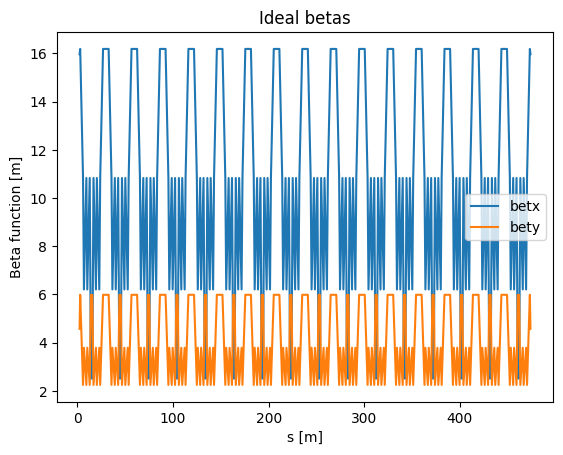

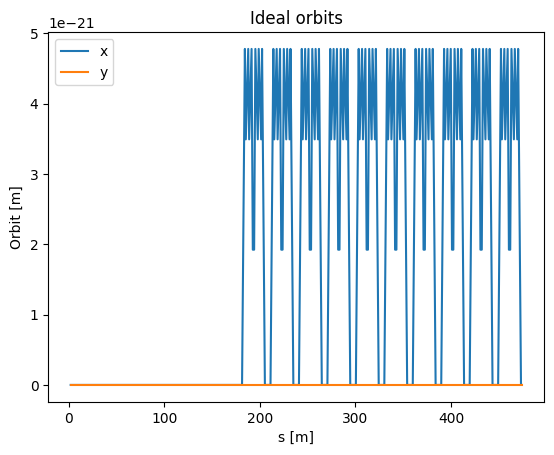

In [10]:
init_optics = get_optics(structure)
plot_optics(init_optics, params_to_show="beta", title="Ideal betas")
plt.show()

plot_optics(init_optics, params_to_show="orbit", title="Ideal orbits")
plt.show()

 21%|██████████████▎                                                      | 500009/2407417 [00:01<00:06, 291550.45it/s]
1799it [00:00, 224837.69it/s]


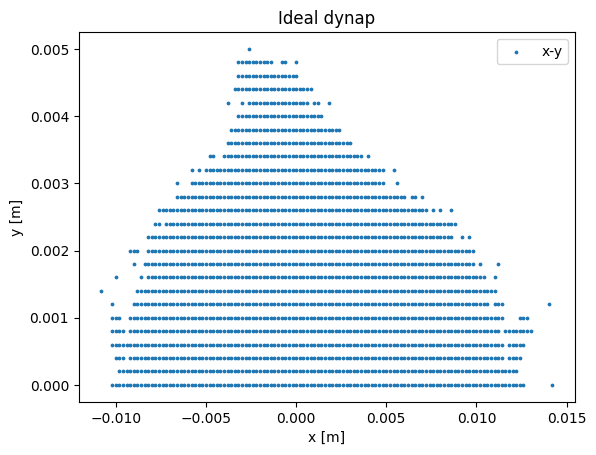

In [11]:
params = {"x": "m",
          "y": "m"}
tab_ideal = read_tracking_file("tracking_data/tracking_skif_xy_1000one.txt", unlost_only=True)
plot_dynap(tab_ideal, params, title="Ideal dynap", plot_name="x-y")
plt.show()

## Elements definition

In [12]:
elems_with_errs = [i for i in structure["elements"] if structure["elements"][i]["type"] not in ["monitor", "marker", "multipole"]]
hcorrs = {i: {"type": "hkicker"} for i in structure["elements"] if structure["elements"][i]["type"] in ["hkicker"]}
vcorrs = {i: {"type": "vkicker"} for i in structure["elements"] if structure["elements"][i]["type"] in ["vkicker"]}
corrs = {"hkicker": hcorrs, "vkicker": vcorrs}
quads = [i for i in structure["elements"] if structure["elements"][i]["type"] in ["quadrupole"]]

structure["kick"] = corrs
print(len(elems_with_errs))

1939


In [13]:
np.random.seed(42)

align_errs = {}
err_type = {"dx": 80e-6, "dy": 80e-6, "ds": 80e-6, "dpsi": 200e-6, "dphi": 200e-6, "dtheta": 200e-6}

for err in err_type:
    err_type_to_add = {err: {"Knobs": {}}}
    for elem in elems_with_errs:
        err_type_to_add[err]["Knobs"][elem] = {"Elements": [elem]}
    err_type_to_add[err]["Values"] = (np.random.normal(scale=err_type[err], size=len(elems_with_errs))).tolist()
    align_errs.update(err_type_to_add)

## Optics with imperfections, sextupoles off

100%|█████████████████████████████████████████████████████████████████████████████| 1939/1939 [00:04<00:00, 412.55it/s]


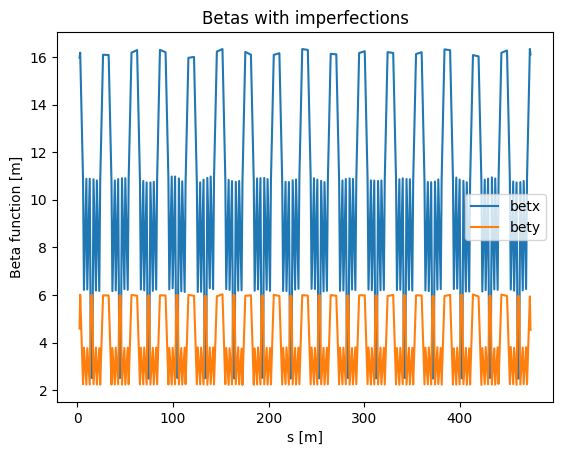

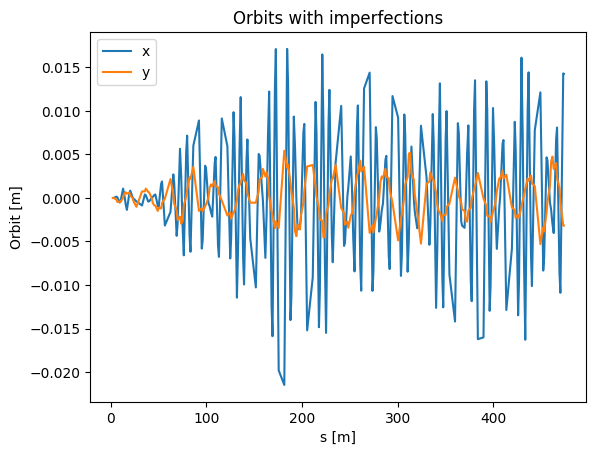

In [14]:
interim_optics_nosext = get_optics(structure_nosext, align_errs)
plot_optics(interim_optics_nosext, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics_nosext, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

 16%|███████████▎                                                         | 500009/3063646 [00:01<00:07, 337695.62it/s]
2it [00:00, ?it/s]


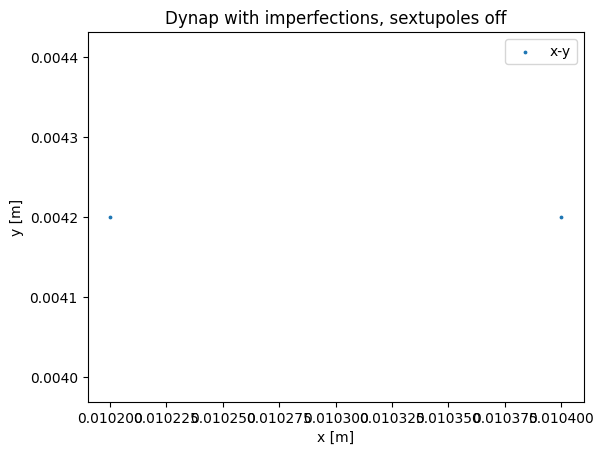

In [19]:
params = {"x": "m",
          "y": "m"}
tab_err = read_tracking_file("tracking_data/tracking_xy_nosext_norad_1000one.txt", unlost_only=True)
plot_dynap(tab_err, params, title="Dynap with imperfections, sextupoles off", plot_name="x-y")
plt.show()

## Optics with imperfections, sextupoles on

In [15]:
interim_optics = get_optics(structure, align_errs)
plot_optics(interim_optics, params_to_show="beta", title="Betas with imperfections")
plt.show()

plot_optics(interim_optics, params_to_show="orbit", title="Orbits with imperfections")
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 1939/1939 [00:04<00:00, 415.29it/s]


Twiss Failed!


TypeError: 'NoneType' object is not subscriptable

100%|█████████████████████████████████████████████████████████████████████▉| 500009/500130 [00:01<00:00, 323839.54it/s]
3it [00:00, 3002.37it/s]


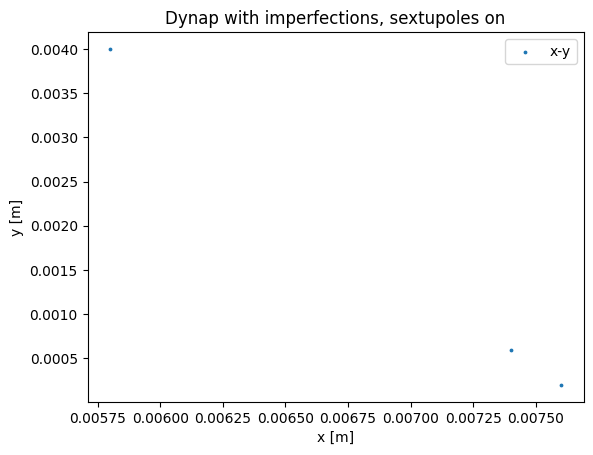

In [16]:
params = {"x": "m",
          "y": "m"}
tab_err = read_tracking_file("tracking_data/tracking_xy_norad_1000one.txt", unlost_only=True)
plot_dynap(tab_err, params, title="Dynap with imperfections, sextupoles on", plot_name="x-y")
plt.show()